# TM10007 Assignment template

In [162]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [205]:
# Data loading functions. Uncomment the one you want to use
# Import other classifiers you plan to use
from worclipo.load_data import load_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from scipy.stats import ttest_ind
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer, accuracy_score
from scipy import stats



data = load_data()
print(f"The number of samples: {len(data.index)}")
print(f"The number of columns: {len(data.columns)}")
print(f"The number of liposarcoma in the dataset: {len(data[data['label'] == 'liposarcoma'])}")
print(f"The number of lipoma in the dataset: {len(data[data['label'] == 'lipoma'])}")

The number of samples: 115
The number of columns: 494
The number of liposarcoma in the dataset: 58
The number of lipoma in the dataset: 57


In [164]:
'''deleting all the columns consisting of only 0's'''

# find the column that contains only zeros
zero_columns = data.columns[data.eq(0).all()]

# Drop columns with only zeros
data_whithout_0 = data.drop(zero_columns, axis=1)


Now we know the number of samples, colums and labels. The next step is to look for missing data. 


In [165]:
def split_data(data_whithout_0):

    # Separate features and target variable
    x = data_whithout_0.drop(['label'], axis=1)
    y = data_whithout_0['label']
    
    # Split the dataset into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    
    return x_train, x_test, y_train, y_test


# Call the function
x_train, x_test, y_train, y_test = split_data(data_whithout_0)

# Optionally, print the sizes of the splits to verify
print("Training set size:", x_train.shape)
print("Testing set size:", x_test.shape)


Training set size: (92, 480)
Testing set size: (23, 480)


In [166]:
outliers_total = 0

for feature in x_train.columns:
    q1 = x_train[feature].quantile(0.25)
    q3 = x_train[feature].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)

    outliers_column = (x_train[feature] < lower_bound).sum() + (x_train[feature] > upper_bound).sum()
    outliers_total += outliers_column

    x_train.loc[x_train[feature] < lower_bound, feature] = lower_bound
    x_train.loc[x_train[feature] > upper_bound, feature] = upper_bound

print(f"{outliers_total} outliers were replaced.")
print(f"This was {round(outliers_total / (len(data.index) * len(data.columns)) *100)}% of the total amount of datapoints.")

C:\Users\31642\AppData\Local\Temp\ipykernel_2476\50788196.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  x_train.loc[x_train[feature] < lower_bound, feature] = lower_bound
C:\Users\31642\AppData\Local\Temp\ipykernel_2476\50788196.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '15.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  x_train.loc[x_train[feature] < lower_bound, feature] = lower_bound
C:\Users\31642\AppData\Local\Temp\ipykernel_2476\50788196.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '18.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  x_train.loc[x_train[feature] < lo

2211 outliers were replaced.
This was 4% of the total amount of datapoints.


Feature normalization

In [167]:
def scaling_data(x_train,x_test):
    scaler = preprocessing.StandardScaler().fit(x_train)

    # Applying scaler to train and test set
    X_train_scaled = pd.DataFrame(scaler.transform(x_train), index=x_train.index, columns=x_train.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(x_test), index=x_test.index, columns=x_test.columns)

    return X_train_scaled, X_test_scaled

X_train_scaled, X_test_scaled = scaling_data(x_train, x_test)


In [168]:
'''checking if train-set is normally distributed'''
lipoma = X_train_scaled[y_train =='lipoma']
liposarcoma = X_train_scaled[y_train =='liposarcoma']
alpha = 0.05
non_gaussian = 0

gaussian_test = pd.DataFrame(columns=['statistic', 'p_value'])
for feature in lipoma.columns:
    statistic, p_value = stats.shapiro(lipoma[feature])
    feature_result = pd.DataFrame({'statistic': statistic, 'p_value': p_value}, index = [feature])
    gaussian_test = pd.concat([gaussian_test, feature_result])
    if p_value < alpha:
        non_gaussian += 1
        
print(f"{non_gaussian} features are not gaussian distributed")


C:\Users\31642\AppData\Local\Temp\ipykernel_2476\1666009437.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gaussian_test = pd.concat([gaussian_test, feature_result])
c:\Users\31642\miniconda3\Lib\site-packages\scipy\stats\_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
c:\Users\31642\miniconda3\Lib\site-packages\scipy\stats\_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
c:\Users\31642\miniconda3\Lib\site-packages\scipy\stats\_morestats.py:1879: UserWarning: Input data for shapiro has 

KeyboardInterrupt: 

Feature selection 

In [ ]:
def manual_feature_selection_ttest(X_train_scaled, y_train):
    '''defiition to calculate the Ttest and P-value of every feature
    input: x_train, y_train
    output: beste 5 festures'''
    
    lipoma = X_train_scaled[y_train =='lipoma']
    liposarcoma = X_train_scaled[y_train =='liposarcoma']

    mwu_result = pd.DataFrame(columns=['statistic', 'p_value'])
    for feature in X_train_scaled.columns:
        statistic, p_value = stats.mannwhitneyu(lipoma[feature], liposarcoma[feature])
        feature_result = pd.DataFrame({'statistic': statistic, 'p_value': p_value}, index = [feature])
        mwu_result = pd.concat([mwu_result, feature_result])
    return mwu_result

def select_features_by_p_value(mwu_result, alpha=0.05):
    '''Definition to select features based on p-value threshold of 0.05'''

    selected_features = mwu_result[mwu_result['p_value'] < alpha].index
    selected_features_df = X_train_scaled[selected_features]
    
    return selected_features_df

mwu_result = manual_feature_selection_ttest(X_train_scaled, y_train)
selected_features_df = select_features_by_p_value(mwu_result, alpha=0.05)

print(selected_features_df.shape)

C:\Users\31642\AppData\Local\Temp\ipykernel_2476\2390329497.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mwu_result = pd.concat([mwu_result, feature_result])


(92, 106)


In [ ]:
def apply_pca_with_variance(X, min_variance):
    '''Definition to apply PCA for dimensionality reduction until a desired variance is achieved'''
    
    pca = PCA()
    X_pca = pca.fit_transform(X)
    explained_variance_ratios = pca.explained_variance_ratio_
    
    # Accumulate explained variances until reaching the desired threshold
    cumulative_variance_ratio = 0.0
    n_components = 0
    for variance_ratio in explained_variance_ratios:
        cumulative_variance_ratio += variance_ratio
        n_components += 1
        if cumulative_variance_ratio >= min_variance:
            break
    
    # Fit PCA again with the selected number of components
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    X_pca_df = pd.DataFrame(X_pca)

    # Print the total explained variance ratio and the number of components
    print("Total explained variance ratio:", cumulative_variance_ratio)
    print("Number of components:", n_components)

    # Obtain eigenvalues
    eigenvalues = pca.explained_variance_
    print("Eigenvalues:", eigenvalues)
    return X_pca_df

min_variance_ratio = 0.88  # 89% of the total explained variance ratio
X_pca_df = apply_pca_with_variance(selected_features_df, min_variance_ratio)

Total explained variance ratio: 0.8892339898767037
Number of components: 15
Eigenvalues: [45.22924742 13.34463068  5.76533108  5.65849508  4.37244717  3.463253
  2.7191931   2.55669258  2.45321094  2.25748286  1.86365488  1.767562
  1.43948072  1.22143522  1.18249722]


Classifiers 

- decision trees
- naive bayes
- linear classifiers
- quadratic classifiers
- ⁠nearest neighbour
- random forrest 
- ⁠support vector machines
- neural network

In [215]:
# Fit LabelEncoder and transform the predicted string labels to numerical labels
label_encoder = LabelEncoder()
y_train_numerical = label_encoder.fit_transform(y_train)

kfold = KFold(n_splits=10, shuffle=True, random_state=42)

clf_rfc = RandomForestClassifier()
param_grid = {
    'n_estimators': range(10, 511, 100),  # Number of trees in the forest
    'max_depth': range(1,51,10),      # Maximum depth of the trees
    'min_samples_split': range(2,11,4),  # Minimum number of samples required to split an internal node
    'min_samples_leaf': range(1,14,4)}  # Minimum number of samples required to be at a leaf node

grid_search = GridSearchCV(estimator=clf_rfc, param_grid=param_grid, cv=kfold, scoring = 'accuracy')
grid_search.fit(X_pca_df, y_train_numerical)

# Get the best hyperparameters
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best accuracy score: {grid_search.best_score_}")

# Voer cross-validation uit en bereken scores voor elke fold
accuracy_scores = cross_val_score(clf_rfc, X_pca_df, y_train_numerical, cv=kfold, scoring=make_scorer(accuracy_score))
precision_scores = cross_val_score(clf_rfc, X_pca_df, y_train_numerical, cv=kfold, scoring=make_scorer(precision_score))
recall_scores = cross_val_score(clf_rfc, X_pca_df, y_train_numerical, cv=kfold, scoring=make_scorer(recall_score))
f1_scores = cross_val_score(clf_rfc, X_pca_df, y_train_numerical, cv=kfold, scoring=make_scorer(f1_score))

# Bereken de gemiddelde scores
mean_accuracy = np.mean(accuracy_scores)
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)
mean_f1 = np.mean(f1_scores)

print("accuracy:", mean_accuracy)
print("precision:", mean_precision)
print("recall:", mean_recall)
print("F1-score:", mean_f1)


Best Hyperparameters: {'max_depth': 31, 'min_samples_leaf': 13, 'min_samples_split': 2, 'n_estimators': 310}
Best accuracy score: 0.7724281274281275
Gemiddelde accuracy: 0.6877777777777778
Gemiddelde precisie: 0.7066666666666668
Gemiddelde recall: 0.6630952380952382
Gemiddelde F1-score: 0.6767748917748918


In [216]:
clf_svm = SVC()

param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf', 'linear', 'poly'],
              'degree': [1, 3, 5]}

grid_search = GridSearchCV(estimator=clf_svm, param_grid=param_grid, cv=kfold, scoring = 'f1', n_jobs=-1)
grid_search.fit(X_pca_df, y_train_numerical)

# Get the best hyperparameters
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best accuracy score: {grid_search.best_score_}")


# Voer cross-validation uit en bereken scores voor elke fold
accuracy_scores = cross_val_score(clf_svm, X_pca_df, y_train_numerical, cv=kfold, scoring=make_scorer(accuracy_score))
precision_scores = cross_val_score(clf_svm, X_pca_df, y_train_numerical, cv=kfold, scoring=make_scorer(precision_score))
recall_scores = cross_val_score(clf_svm, X_pca_df, y_train_numerical, cv=kfold, scoring=make_scorer(recall_score))
f1_scores = cross_val_score(clf_svm, X_pca_df, y_train_numerical, cv=kfold, scoring=make_scorer(f1_score))

# Bereken de gemiddelde scores
mean_accuracy = np.mean(accuracy_scores)
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)
mean_f1 = np.mean(f1_scores)

print("accuracy:", mean_accuracy)
print("precision:", mean_precision)
print("recall:", mean_recall)
print("F1-score:", mean_f1)


Best Hyperparameters: {'C': 10, 'degree': 1, 'gamma': 1, 'kernel': 'linear'}
Best f1 score: 0.7496309246309247
Gemiddelde accuracy: 0.721111111111111
Gemiddelde precisie: 0.7845238095238095
Gemiddelde recall: 0.6997619047619048
Gemiddelde F1-score: 0.7252597402597403


In [217]:
clf_knn = KNeighborsClassifier()

param_grid = {'n_neighbors': [3, 5, 7, 9],
              'weights': ['uniform', 'distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1, 2]}  # 1 for Manhattan distance, 2 for Euclidean distance

grid_search = GridSearchCV(estimator=clf_knn, param_grid=param_grid, cv=kfold, scoring = 'f1', n_jobs=-1)
grid_search.fit(X_pca_df, y_train)

# Get the best hyperparameters
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best accuracy score: {grid_search.best_score_}")

# Voer cross-validation uit en bereken scores voor elke fold
accuracy_scores = cross_val_score(clf_knn, X_pca_df, y_train_numerical, cv=kfold, scoring=make_scorer(accuracy_score))
precision_scores = cross_val_score(clf_knn, X_pca_df, y_train_numerical, cv=kfold, scoring=make_scorer(precision_score))
recall_scores = cross_val_score(clf_knn, X_pca_df, y_train_numerical, cv=kfold, scoring=make_scorer(recall_score))
f1_scores = cross_val_score(clf_knn, X_pca_df, y_train_numerical, cv=kfold, scoring=make_scorer(f1_score))

# Bereken de gemiddelde scores
mean_accuracy = np.mean(accuracy_scores)
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)
mean_f1 = np.mean(f1_scores)

print("accuracy:", mean_accuracy)
print("precision:", mean_precision)
print("recall:", mean_recall)
print("F1-score:", mean_f1)



Best Hyperparameters: {'algorithm': 'auto', 'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}
Best accuracy score: 0.6814285714285714
Gemiddelde accuracy: 0.6244444444444445
Gemiddelde precisie: 0.6928571428571428
Gemiddelde recall: 0.6347619047619049
Gemiddelde F1-score: 0.6175796425796426


c:\Users\31642\miniconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [0.64809524 0.64809524 0.59931624 0.59931624 0.61773449 0.61773449
 0.61757964 0.63662726 0.63015873 0.63015873 0.65003053 0.66907814
 0.67175214 0.67175214 0.68142857 0.68142857 0.64809524 0.64809524
 0.59931624 0.59931624 0.61773449 0.61773449 0.61757964 0.63662726
 0.63015873 0.63015873 0.65003053 0.66907814 0.67175214 0.67175214
 0.68142857 0.68142857 0.64809524 0.64809524 0.59931624 0.59931624
 0.61773449 0.61773449 0.61757964 0.63662726 0.63015873 0.63015873
 0.65003053 0.66907814 0.67175214 0.67175214 0.68142857 0.68142857
        nan 0.64809524        nan 0.59931624        nan 0.61773449
        nan 0.63662726        nan 0.63015873        nan 0.66907814
        nan 0.67175214        nan 0.68142857]
  warnings.warn(


In [218]:
clf_dt = DecisionTreeClassifier()

param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [None, 10, 20, 30],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_features': ['auto', 'sqrt', 'log2']}

grid_search = GridSearchCV(estimator=clf_dt, param_grid=param_grid, cv=kfold, scoring = 'f1', n_jobs=-1)
grid_search.fit(X_pca_df, y_train)

# Get the best hyperparameters
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best accuracy score: {grid_search.best_score_}")

# Voer cross-validation uit en bereken scores voor elke fold
accuracy_scores = cross_val_score(clf_dt, X_pca_df, y_train_numerical, cv=kfold, scoring=make_scorer(accuracy_score))
precision_scores = cross_val_score(clf_dt, X_pca_df, y_train_numerical, cv=kfold, scoring=make_scorer(precision_score))
recall_scores = cross_val_score(clf_dt, X_pca_df, y_train_numerical, cv=kfold, scoring=make_scorer(recall_score))
f1_scores = cross_val_score(clf_dt, X_pca_df, y_train_numerical, cv=kfold, scoring=make_scorer(f1_score))

# Bereken de gemiddelde scores
mean_accuracy = np.mean(accuracy_scores)
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)
mean_f1 = np.mean(f1_scores)

print("accuracy:", mean_accuracy)
print("precision:", mean_precision)
print("recall:", mean_recall)
print("F1-score:", mean_f1)


Best Hyperparameters: {'criterion': 'gini', 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2}
Best accuracy score: 0.7246309246309247
Gemiddelde accuracy: 0.6655555555555556
Gemiddelde precisie: 0.7011904761904761
Gemiddelde recall: 0.7080952380952381
Gemiddelde F1-score: 0.6526373626373625


c:\Users\31642\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
720 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
492 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\31642\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\31642\miniconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\31642\miniconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\31642\miniconda3\Lib\site-

In [ ]:
clf_mlp = MLPClassifier()

# Create the hidden layer size variable
size_hidden_layers = []
for a in range(5,156,50):
    for b in range(5,156,50):
        size_hidden_layers.append((a,b))

param_grid = {'hidden_layer_sizes': size_hidden_layers,
              'activation': ['identity', 'logistic', 'tanh', 'relu'],
              'solver': ['lbfgs', 'sgd', 'adam'],
              'alpha': [0.000001, 0.00001, 0.0001, 0.001, 0.01],
              'learning_rate': ['constant', 'invscaling','adaptive'],
              'max_iter': range(100,1001,100)}

mlp_search = GridSearchCV(estimator=clf_mlp, param_grid=param_grid, scoring = 'f1', n_jobs=-1, cv=kfold)
mlp_search.fit(X_pca_df,y_train)

# Get the best hyperparameters
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best accuracy score: {grid_search.best_score_}")

# Voer cross-validation uit en bereken scores voor elke fold
accuracy_scores = cross_val_score(clf_mlp, X_pca_df, y_train_numerical, cv=kfold, scoring=make_scorer(accuracy_score))
precision_scores = cross_val_score(clf_mlp, X_pca_df, y_train_numerical, cv=kfold, scoring=make_scorer(precision_score))
recall_scores = cross_val_score(clf_mlp, X_pca_df, y_train_numerical, cv=kfold, scoring=make_scorer(recall_score))
f1_scores = cross_val_score(clf_mlp, X_pca_df, y_train_numerical, cv=kfold, scoring=make_scorer(f1_score))

# Bereken de gemiddelde scores
mean_accuracy = np.mean(accuracy_scores)
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)
mean_f1 = np.mean(f1_scores)

print("accuracy:", mean_accuracy)
print("precision:", mean_precision)
print("recall:", mean_recall)
print("F1-score:", mean_f1)


KeyboardInterrupt: 

c:\Users\31642\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\31642\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\31642\miniconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\31642\miniconda3\Lib\site-packages\sklearn\base.py", line 705, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "c:\Users\31642\miniconda3\Lib\site-packages\sklearn\neighbors\_classification.py", line 246, in predict
    if self._fit_method == "brute" and 

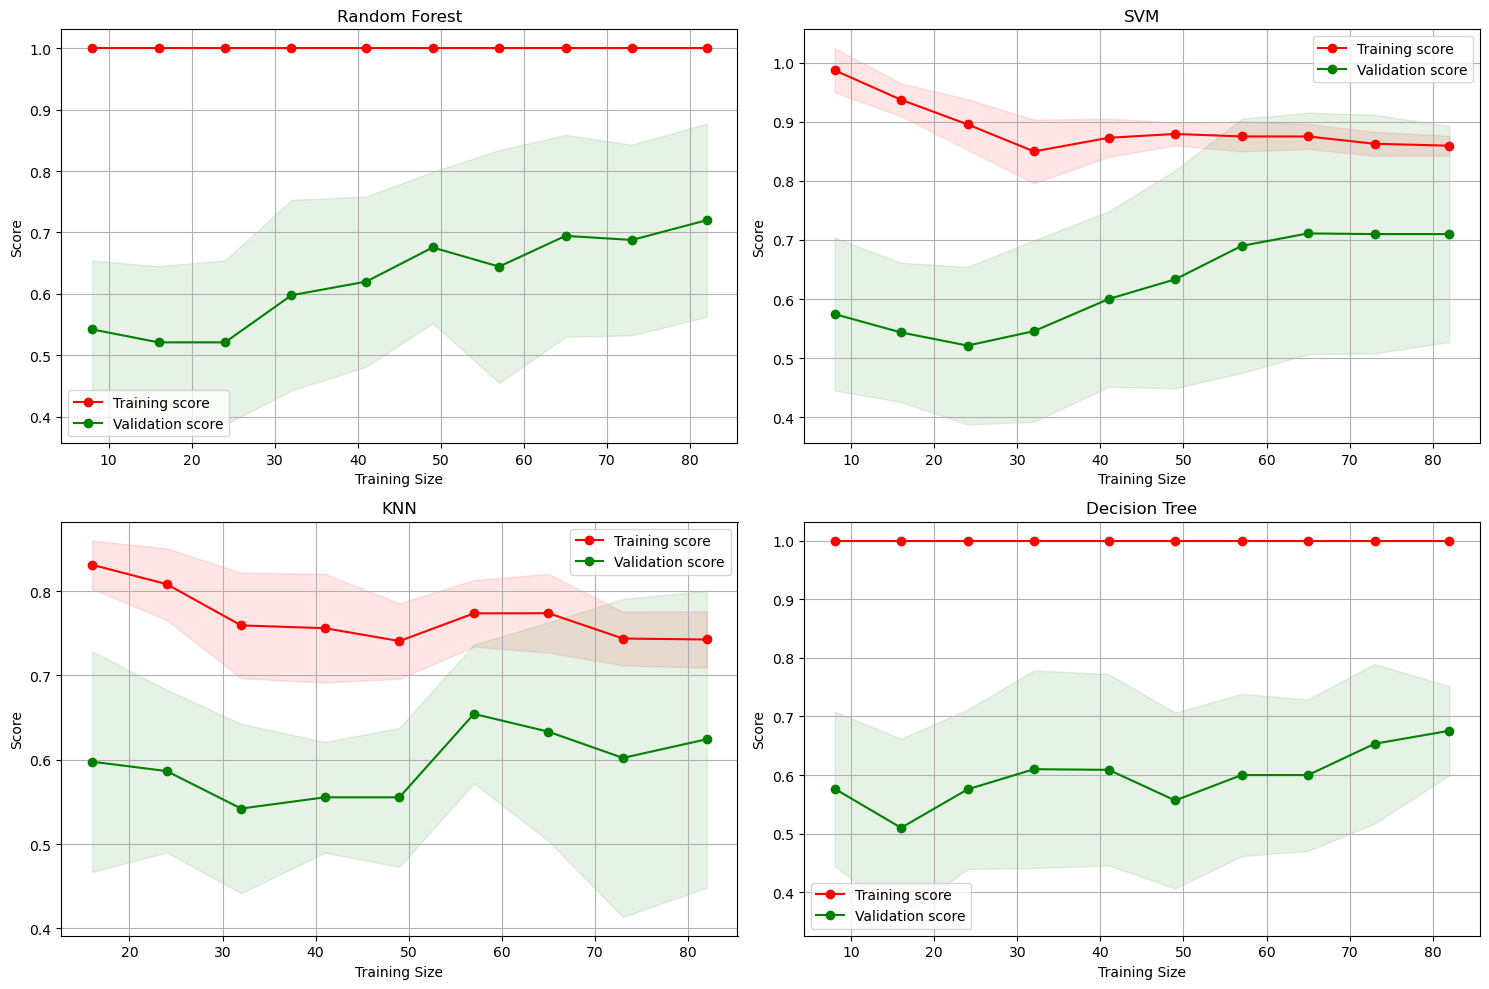

In [219]:
from sklearn.model_selection import learning_curve

def plot_learning_curves_for_multiple_models(models, names, X, y, cv=kfold, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 10)):
    """
    Plots learning curves for multiple models in a single figure with subplots.

    Parameters:
    - models: List of sklearn model instances.
    - names: List of model names as strings for titles.
    - X: Features matrix.
    - y: Target vector.
    - cv: Number of cross-validation folds.
    - n_jobs: Number of jobs to run in parallel (-1 means using all processors).
    - train_sizes: Fraction of the dataset to generate learning curves.
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()
    
    for ax, model, name in zip(axes, models, names):
        train_sizes, train_scores, test_scores = learning_curve(
            model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
        
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)
        test_std = np.std(test_scores, axis=1)
        
        ax.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
        ax.plot(train_sizes, test_mean, 'o-', color="g", label="Validation score")
        ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
        ax.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
        
        ax.set_title(name)
        ax.set_xlabel('Training Size')
        ax.set_ylabel('Score')
        ax.legend(loc="best")
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

models = [clf_rfc, clf_svm, clf_knn, clf_dt]
names = ["Random Forest", "SVM", "KNN", "Decision Tree"]
plot_learning_curves_for_multiple_models(models, names, X_pca_df, y_train, cv=kfold, n_jobs=None)